In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
import sys
sys.path.append('/home/coolshan/Project/Efficient-Pytorch-Template')
from ml_template.utils import *
from ml_template.model.ml_model import *
data_df = pd.read_excel('data/train.xlsx')
test_df = pd.read_excel('data/test.xlsx')
submission_df = pd.read_csv('data/submission.csv')

In [2]:
data = data_df.values[:,:-1]
label=data_df.values[:,-1]
qt = QuantileTransformer(n_quantiles=100)
data = qt.fit_transform(data)

In [3]:
# split 9:1 
train_data, train_label, test_data, test_label = KFold_Sampler(data,label,n_splits=100).get_multi_fold_data(n_fold=10)
print(len(train_data),len(test_data),len(test_data)/(len(train_data)+len(test_data)))

# define model list
model_lgb = lgb.LGBMClassifier(is_unbalance=True)

model_dict = {'RF_3':RandomForestClassifier(n_estimators=310,max_depth=3),
              'RF_depth_None':RandomForestClassifier(n_estimators=310),
              'XGB_31_3':XGBClassifier(n_estimators=31,max_depth=3),
              'XGB_310_3':XGBClassifier(n_estimators=31,max_depth=3),
              'XGB_31':XGBClassifier(n_estimators=31),
              'XGB_310':XGBClassifier(n_estimators=310),
              'SVM':SVC(probability=True),
              'SVM_lin':SVC(kernel='linear',probability=True),
              'SVM_rbf':SVC(kernel='rbf',probability=True),
              'SVM_0.2':SVC(C=0.2,probability=True),
              'SVM_0.2_lin':SVC(C=0.2,kernel='linear',probability=True),
              'SVM_0.2_poly':SVC(C=0.2,kernel='poly',probability=True),
              'SVM_5':SVC(C=5,probability=True),
              'SVM_5_lin':SVC(C=5,kernel='linear',probability=True),
              'SVM_5_poly':SVC(C=5,kernel='poly',probability=True),
              # 'KNN_Cls':KNeighborsClassifier(),
              'LGB_Cls':model_lgb,
              # 'Ridge_Cls':RidgeClassifier(),
              # 'MLP_Cls':MLPClassifier(activation = "relu", alpha = 0.001, hidden_layer_sizes = (56,10),
              #               learning_rate = "constant", max_iter = 3000, random_state = 3000,early_stopping=True),
              # 'QDA':QuadraticDiscriminantAnalysis(),
              }
#stack_model=MLPClassifier(activation = "relu", alpha = 0.0001,validation_fraction=0.1, hidden_layer_sizes = (38),learning_rate = "constant", max_iter = 3000, random_state = 1000,early_stopping=True)
# stack_model=SVC(C=1,kernel='linear', probability=True)
#stack_model = DecisionTreeClassifier()
model = Stack_Ensemble_Proba_Model(copy.deepcopy(model_dict),stack_model=ML_Weighted_Model(len(list(model_dict.keys())),2,
                                                                                                     model_reg=0.00,
                                                                                                     classes_reg=0.00,
                                                                                                     l1_norm=0.00),stack_training_split=0.2)
# model = Mean_Ensemble_Proba_Model(copy.deepcopy(model_dict))
cv_model, cv_df = model.cross_validation_evaluate(train_data, train_label, accuracy_score,n_splits=5)

3510 393 0.10069177555726365


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.9936, 0.9936],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0420, 1.0420],
        [1.1192, 1.1192],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.8991, 0.8991],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0956, 1.0956]], requires_grad=True)




====== CV:0 ======
             model  eval_metric
0             RF_3     0.650997
1        SVM_5_lin     0.676638
2      SVM_0.2_lin     0.680912
3          SVM_lin     0.682336
4     SVM_0.2_poly     0.690883
5          SVM_0.2     0.690883
6            SVM_5     0.699430
7          LGB_Cls     0.700855
8       SVM_5_poly     0.705128
9          SVM_rbf     0.705128
10             SVM     0.705128
11       XGB_310_3     0.709402
12        XGB_31_3     0.709402
13   RF_depth_None     0.713675
14          XGB_31     0.719373
15  Ensemble Model     0.725071
16         XGB_310     0.729345


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.9580, 0.9580],
        [0.7267, 0.7267],
        [0.7267, 0.7267],
        [1.0718, 1.0718],
        [1.1086, 1.1086],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0870, 1.0870]], requires_grad=True)




====== CV:1 ======
             model  eval_metric
0      SVM_0.2_lin     0.675214
1          SVM_lin     0.680912
2             RF_3     0.682336
3        SVM_5_lin     0.683761
4          SVM_0.2     0.692308
5              SVM     0.717949
6          SVM_rbf     0.717949
7       SVM_5_poly     0.720798
8          LGB_Cls     0.722222
9     SVM_0.2_poly     0.723647
10       XGB_310_3     0.726496
11        XGB_31_3     0.726496
12          XGB_31     0.732194
13  Ensemble Model     0.733618
14         XGB_310     0.737892
15           SVM_5     0.740741
16   RF_depth_None     0.740741


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.9089, 0.9089],
        [0.7449, 0.7449],
        [0.7449, 0.7449],
        [1.0634, 1.0634],
        [1.1069, 1.1069],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.4137, 0.4137],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0725, 1.0725]], requires_grad=True)




====== CV:2 ======
             model  eval_metric
0             RF_3     0.662393
1      SVM_0.2_lin     0.662393
2          SVM_lin     0.672365
3        SVM_5_lin     0.679487
4          SVM_0.2     0.690883
5     SVM_0.2_poly     0.709402
6           XGB_31     0.710826
7          SVM_rbf     0.712251
8          XGB_310     0.712251
9              SVM     0.719373
10      SVM_5_poly     0.723647
11       XGB_310_3     0.726496
12        XGB_31_3     0.726496
13           SVM_5     0.727920
14         LGB_Cls     0.729345
15  Ensemble Model     0.729345
16   RF_depth_None     0.760684


Parameter containing:
tensor([[0.0000, 0.0000],
        [1.0244, 1.0244],
        [0.1748, 0.1748],
        [0.1748, 0.1748],
        [1.0513, 1.0513],
        [1.1062, 1.1062],
        [0.3928, 0.3928],
        [0.0000, 0.0000],
        [0.0738, 0.0738],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0181, 1.0181],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0749, 1.0749]], requires_grad=True)




====== CV:3 ======
             model  eval_metric
0             RF_3     0.669516
1     SVM_0.2_poly     0.679487
2          SVM_0.2     0.685185
3          SVM_rbf     0.688034
4          XGB_310     0.692308
5        SVM_5_lin     0.692308
6              SVM     0.693732
7          SVM_lin     0.695157
8      SVM_0.2_lin     0.695157
9           XGB_31     0.699430
10      SVM_5_poly     0.699430
11         LGB_Cls     0.702279
12           SVM_5     0.702279
13        XGB_31_3     0.705128
14       XGB_310_3     0.705128
15   RF_depth_None     0.722222
16  Ensemble Model     0.727920


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.8487, 0.8487],
        [0.6074, 0.6074],
        [0.6074, 0.6074],
        [1.0665, 1.0665],
        [1.1164, 1.1164],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0922, 1.0922]], requires_grad=True)




====== CV:4 ======
             model  eval_metric
0      SVM_0.2_lin     0.668091
1          SVM_lin     0.672365
2             RF_3     0.678063
3        SVM_5_lin     0.685185
4          SVM_0.2     0.692308
5     SVM_0.2_poly     0.717949
6              SVM     0.719373
7          SVM_rbf     0.720798
8        XGB_310_3     0.720798
9         XGB_31_3     0.720798
10         LGB_Cls     0.729345
11         XGB_310     0.732194
12      SVM_5_poly     0.733618
13          XGB_31     0.737892
14           SVM_5     0.737892
15   RF_depth_None     0.752137
16  Ensemble Model     0.756410

====== CV Mean ======
             model  eval_metric
0             RF_3     0.668661
1      SVM_0.2_lin     0.676353
2          SVM_lin     0.680627
3        SVM_5_lin     0.683476
4          SVM_0.2     0.690313
5     SVM_0.2_poly     0.704274
6          SVM_rbf     0.708832
7              SVM     0.711111
8       SVM_5_poly     0.716524
9          LGB_Cls     0.716809
10        XGB_31_3     0.717

array([0.        , 0.94668484, 0.45075756, 0.45075756, 1.0590093 ,
       1.1114562 , 0.07856727, 0.        , 0.01475257, 0.        ,
       0.        , 0.        , 0.466189  , 0.        , 0.        ,
       1.0844471 ], dtype=float32)

['RF_3',
 'RF_depth_None',
 'XGB_31_3',
 'XGB_310_3',
 'XGB_31',
 'XGB_310',
 'SVM',
 'SVM_lin',
 'SVM_rbf',
 'SVM_0.2',
 'SVM_0.2_lin',
 'SVM_0.2_poly',
 'SVM_5',
 'SVM_5_lin',
 'SVM_5_poly',
 'LGB_Cls']

array([[0.  , 0.  ],
       [0.95, 0.95],
       [0.45, 0.45],
       [0.45, 0.45],
       [1.06, 1.06],
       [1.11, 1.11],
       [0.08, 0.08],
       [0.  , 0.  ],
       [0.01, 0.01],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.47, 0.47],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [1.08, 1.08]], dtype=float32)

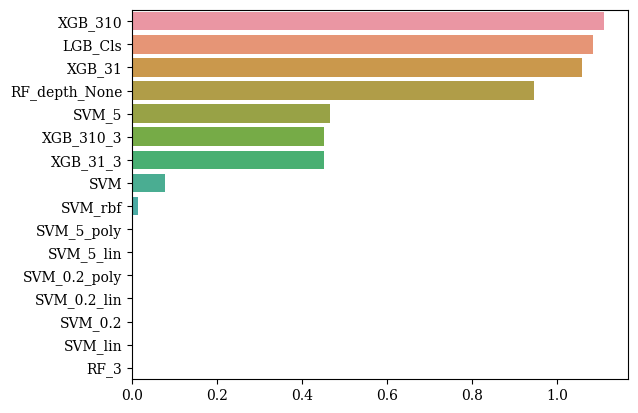

In [4]:
weights = cv_model[0].stack_model.weights.data.detach().numpy()
for i in range(1,len(cv_model)):
  weights = np.add(cv_model[i].stack_model.weights.data.detach().numpy(),weights)

weights = weights/len(cv_model)
importance = np.array(weights.mean(axis=1))
model_name = list(model_dict.keys())
display(importance,model_name)
display(np.round(weights,decimals=2))
zipped = list(zip(model_name,importance))
sorted_zipped = sorted(zipped, key=lambda x: x[1])[::-1]
model_name, importance = zip(*sorted_zipped)
importance = np.array(importance)
sns.barplot(y=list(model_name),x=importance)
plt.show()

In [ ]:
stack_model = ML_Weighted_Model(5,2,epoch=10000,init_mode='rand',l1_norm=0)

In [ ]:

#stack_model = DecisionTreeClassifier()
cv_ensemble_model = Stack_Ensemble_Proba_Model(model_dict=cv_model, stack_model=copy.deepcopy(stack_model), stack_training_split=0.3)
# cv_ensemble_model = Mean_Ensemble_Proba_Model(cv_model)
cv_ensemble_model.fit(train_data,train_label)
# # cv_ensemble_model.fit(train_data,train_label)
# print('========== Ensemble Model ==========')
# _=model.evaluate(test_data,test_label,evaluation_fn=accuracy_score,verbose=True)
print('========== CV Ensemble Model ==========')
_=cv_ensemble_model.evaluate(test_data,test_label,evaluation_fn=accuracy_score,verbose=True)

In [ ]:
cv_ensemble_model.evaluate(train_data,train_label,accuracy_score)

In [ ]:
test_data = test_df.values[:,1:]
test_data = qt.transform(test_data)
test_pred = model.predict(test_data)
test_pred

In [ ]:
import torch